In [3]:
gauged_reaches=c(4, 544, 568, 562, 658, 571, 653, 662, 668, 665, 575, 584, 674, 593, 677, 681, 678, 687, 796, 689, 619, 694, 702, 613, 613, 613, 698, 635, 627, 704, 639, 639, 719, 710, 643, 737, 739, 554, 750, 759, 764, 775, 802, 803, 520, 877, 836, 916, 539, 1331, 305, 307, 341, 345, 347, 887, 890, 891, 893, 903, 901, 896, 905, 957, 965, 952, 937, 947, 946, 941, 944, 939, 1150, 1139, 1141, 1126, 1154, 1174, 1203, 1202, 1198, 1197, 1208, 1310, 1228, 1220, 1298, 1214, 1262, 1274, 1288, 1268, 1278, 1303, 1290, 1282, 1336, 1307, 1325, 51, 47, 30, 36, 40, 43, 421, 54, 166, 59, 63, 424, 435, 456, 482, 328, 338, 335, 1077, 997, 998, 1117, 1001, 1013, 1016, 1029, 1041, 1044, 1245, 1052, 1255, 1246)

In [31]:
setwd('/nas/cee-water/cjgleason/colin/neobam/')

 for (i in 1:length(gauged_reaches)){
  # i=22

index=gauged_reaches[i]
source('run_neobam.R')

  outname=paste0('/nas/cee-water/cjgleason/colin/neobam/tempoutput/output',as.character(i),'.rds')
saveRDS(neobam_output,file=outname)
      
 }





[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74261000041 : 0.103057146072388 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74265000021 : 0.0791604518890381 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266300131 : 0.111665725708008 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266300071 : 0.0888869762420654 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266700101 : 0.0762996673583984 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266400031 : 0.0981082916259766 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266700051 : 0.0951676368713379 seconds."
[1] "in get_inp

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74266900041 : 1.47852474848429 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266900131 : 0.106741189956665 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266400451 : 0.0885593891143799 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266400451 : 0.089221715927124 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266400451 : 0.0786821842193604 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266900081 : 0.0818092823028564 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266400671 : 0.0729951858520508 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execut

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74266900491 : 13.9592432975769 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74266900511 : 0.127837657928467 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74265000121 : 0.122704029083252 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267200031 : 0.0897946357727051 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267200121 : 0.0700821876525879 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267200171 : 0.0842716693878174 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267200281 : 0.0959024429321289 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.84, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267300181 : 2.2575107773145 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267300191 : 0.111889839172363 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74264700381 : 0.125295400619507 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267500041 : 12.6175627708435 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267400131 : 0.0811600685119629 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267700141 : 0.0927822589874268 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74264900071 : 0.0869638919830322 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.79, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269900761 : 22.6857523918152 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262700531 : 0.0813088417053223 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262700551 : 0.0827252864837646 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262800311 : 0.115427017211914 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.84, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74262800351 : 3.03730405966441 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74262800371 : 1.45190521081289 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600061 : 0.0961699485778809 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600091 : 0.10783052444458 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600101 : 0.131873369216919 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600121 : 0.0778160095214844 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600221 : 0.0729601383209229 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267600201 : 25.6855006217957 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.82, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267600151 : 17.7054491043091 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267600241 : 0.0912566184997559 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800251 : 0.088139533996582 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800341 : 0.117870807647705 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800201 : 0.0977087020874023 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800051 : 0.0729198455810547 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800151 : 0.0883376598358154 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267800141 : 36.6036298274994 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.74, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74267800091 : 9.96243929862976 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800121 : 0.0806350708007812 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74267800071 : 0.0846121311187744 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269400291 : 0.0788919925689697 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269400181 : 0.0956220626831055 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269400201 : 0.0778396129608154 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269400041 : 14.8734242916107 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269400331 : 1.19061561028163 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269500051 : 0.080946683883667 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269600111 : 0.112236976623535 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269600101 : 0.0799217224121094 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269600061 : 0.105064153671265 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269600051 : 0.100624561309814 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269700031 : 40.6682088375092 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900551 : 0.122519969940186 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269800211 : 0.112812042236328 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269800111 : 0.0739459991455078 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269900431 : 1.13287855784098 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269800051 : 0.111499547958374 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900071 : 0.119235515594482 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900191 : 0.0947988033294678 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900331 : 0.0733518600463867 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900131 : 0.0867483615875244 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900231 : 0.0778679847717285 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269900481 : 3.06945391496023 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900351 : 0.108096599578857 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900271 : 0.0886576175689697 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.84, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269900811 : 36.0130376815796 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269900521 : 0.0978717803955078 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269900701 : 1.44341797033946 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200241 : 0.105374336242676 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200201 : 0.104752540588379 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200031 : 0.100443124771118 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200091 : 0.0712282657623291 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200131 : 0.090181827545166 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74262200161 : 0.0708377361297607 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total executio

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74268400041 : 30.9893491268158 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74268500061 : 0.138110637664795 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.84, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74268600011 : 1.43124625285467 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74268700061 : 2.9008260567983 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74268800021 : 1.22094216346741 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.83, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74268800051 : 50.208003282547 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269800381 : 0.118365049362183 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74268800131 : 0.119219779968262 seconds."
[1] "in get_input(), neobam has decided the data are invalid"
[1] "Total execution time for reach 74269800481 : 0.0986418724060059 seconds."


code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

code for methods in class “Rcpp_stan_fit4model2fb855a73ed97_neobam_stan_engine” was not checked for suspicious field assignments (recommended package ‘codetools’ not available?)

Warning message:
“There were 5400 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“There were 3 chains where the estimated Bayesian Fraction of Missing Information was low. See
https://mc-stan.org/misc/warnings.html#bfmi-low”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”
Warning message:
“The largest R-hat is 3.81, indicating chains have not mixed.
Running the chains for more iterations may help. See
https://mc-stan.org/misc/warnings.html#r-hat”
Warning message:
“

[1] "Total execution time for reach 74269800391 : 30.6819641590118 seconds."


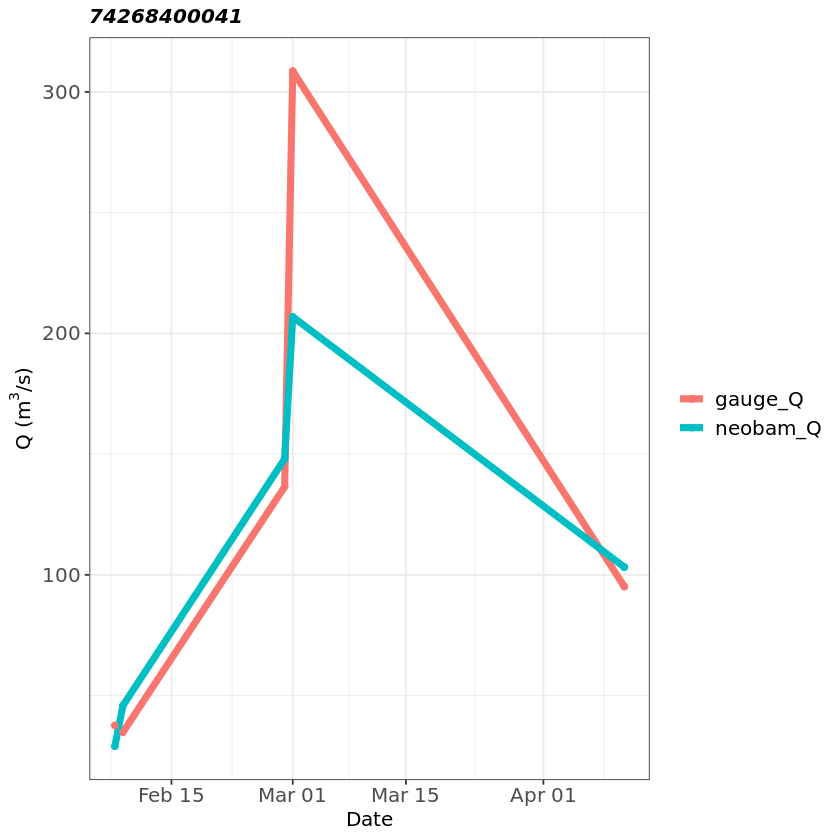

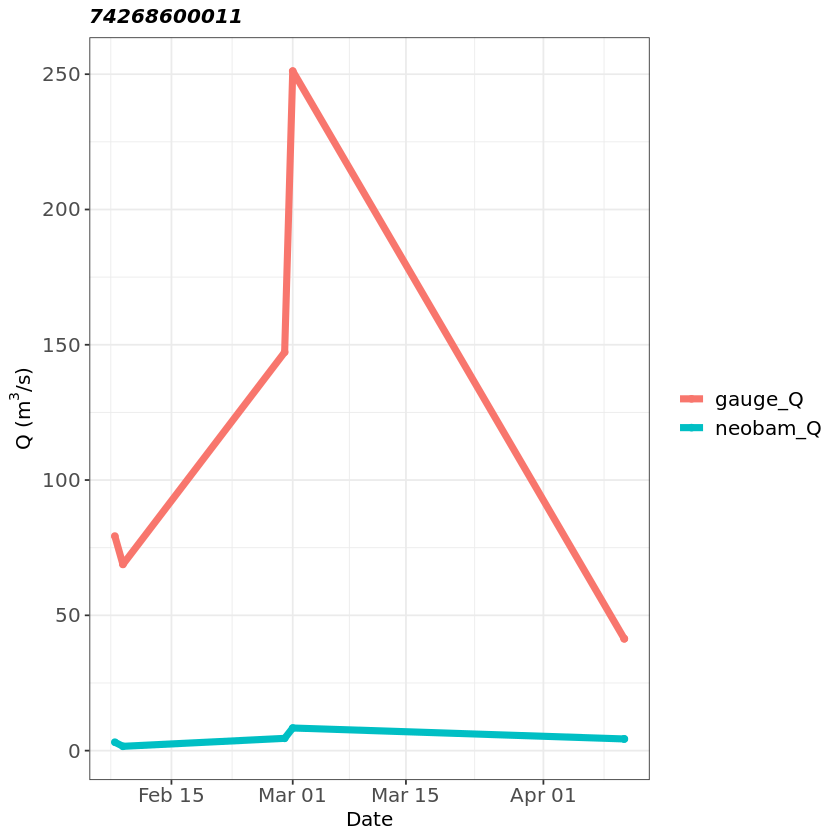

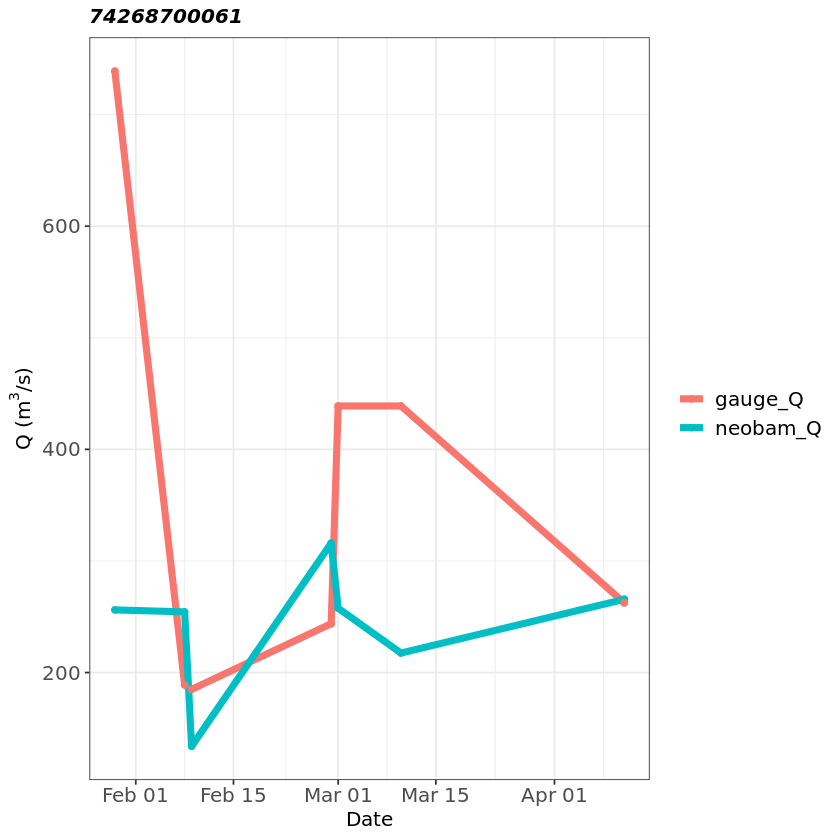

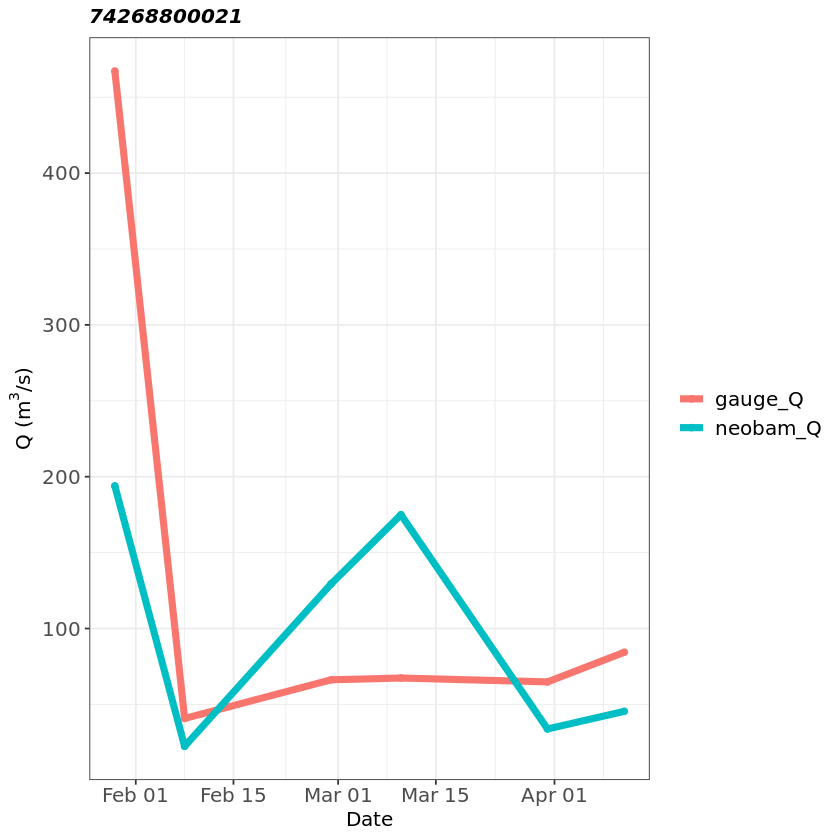

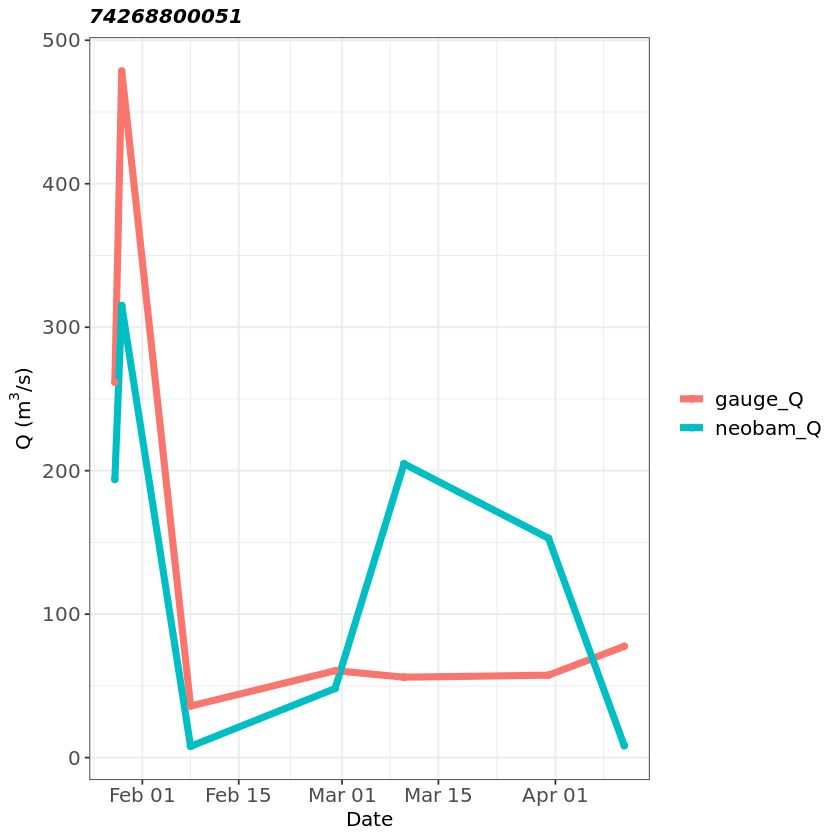

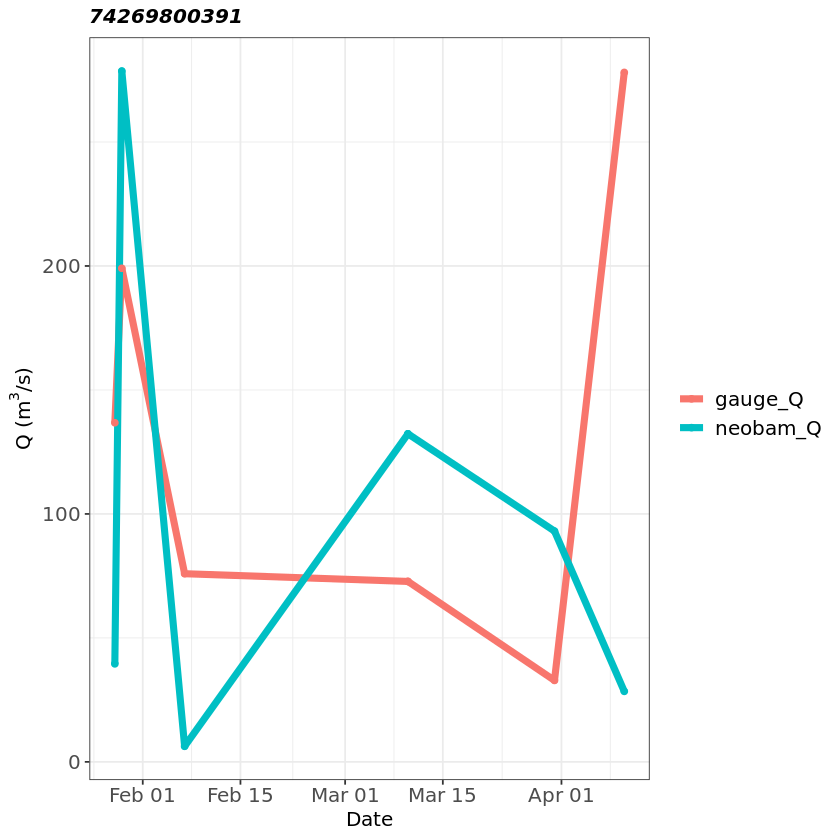

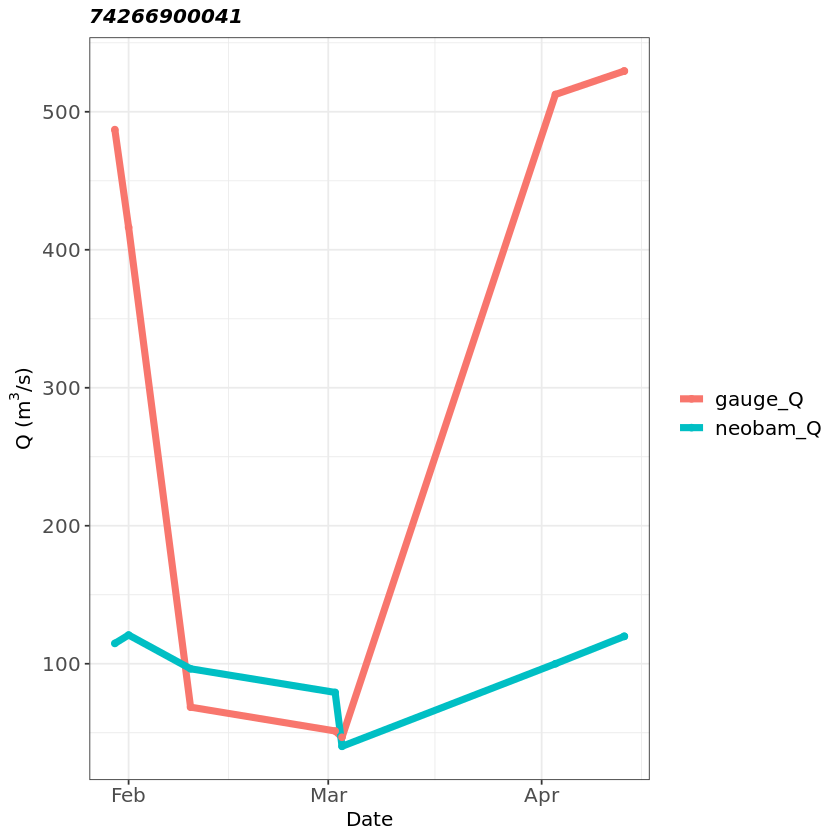

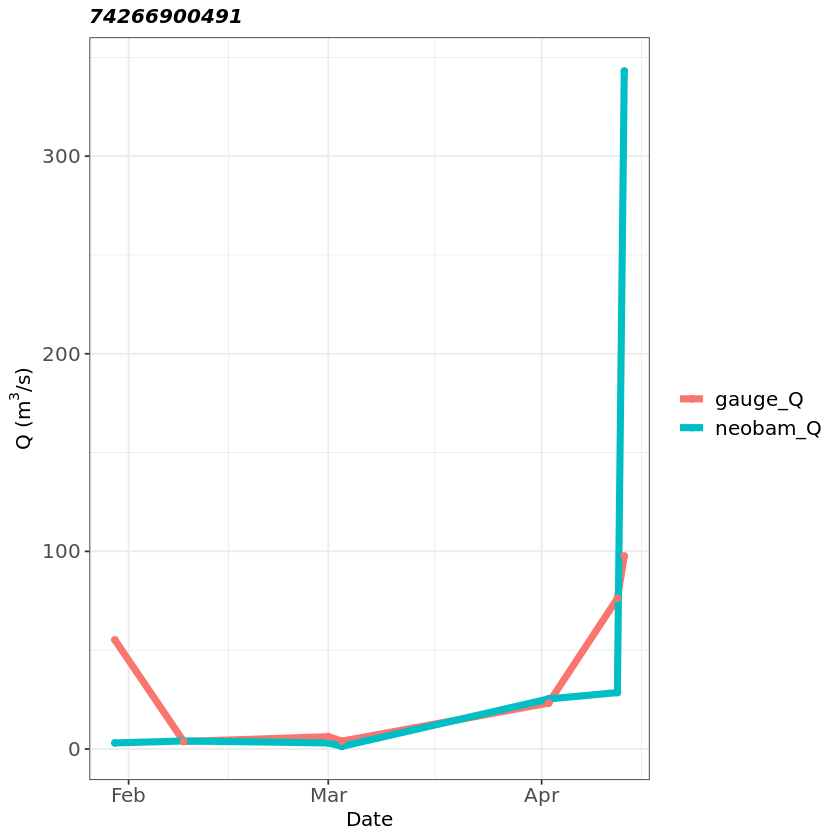

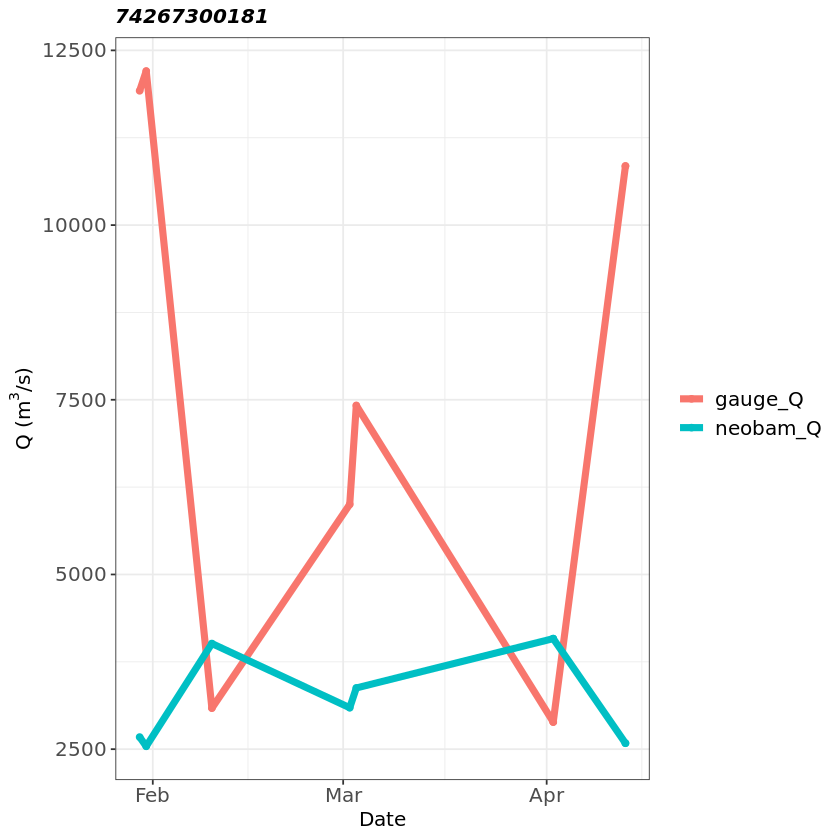

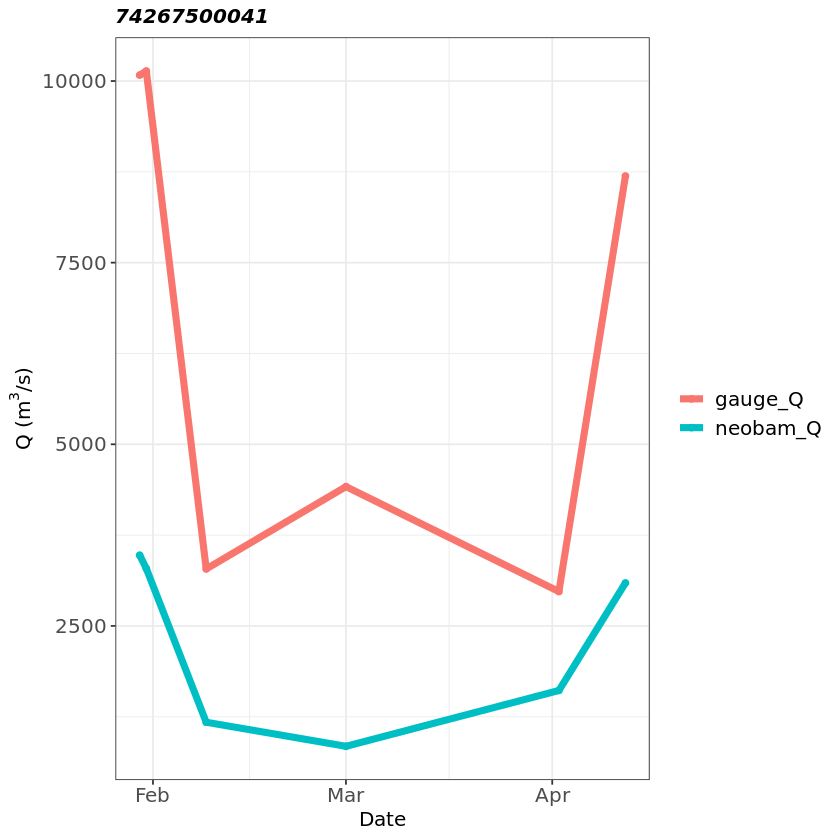

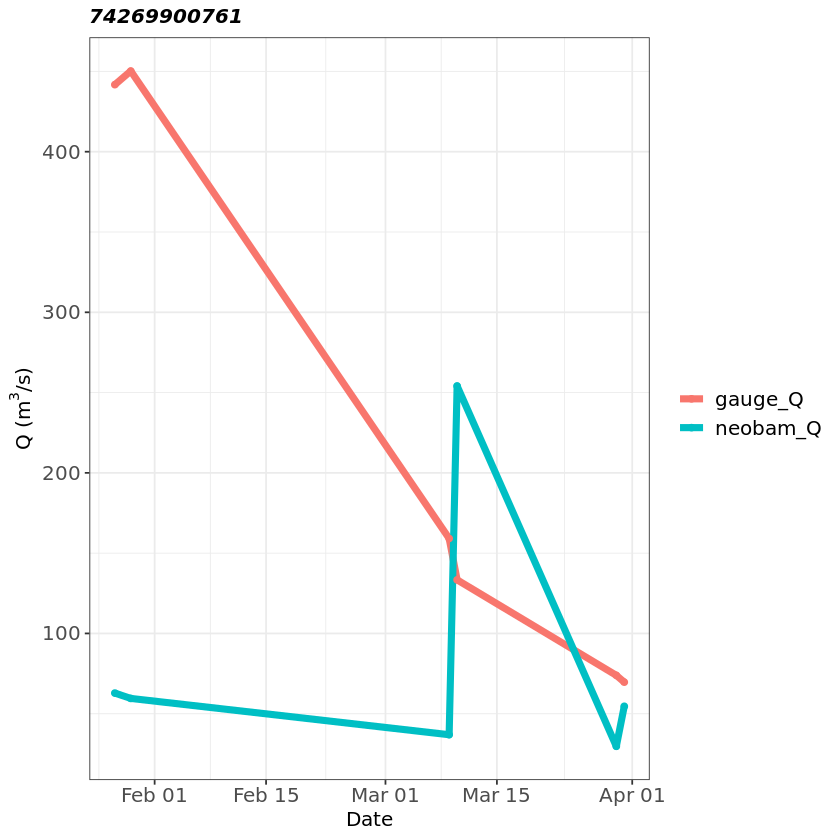

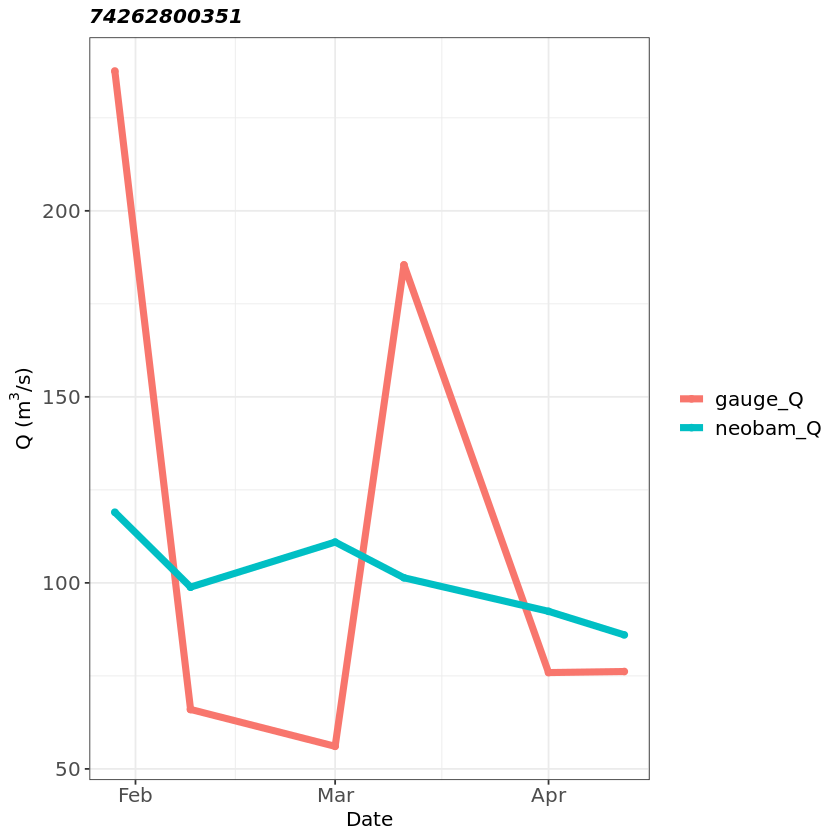

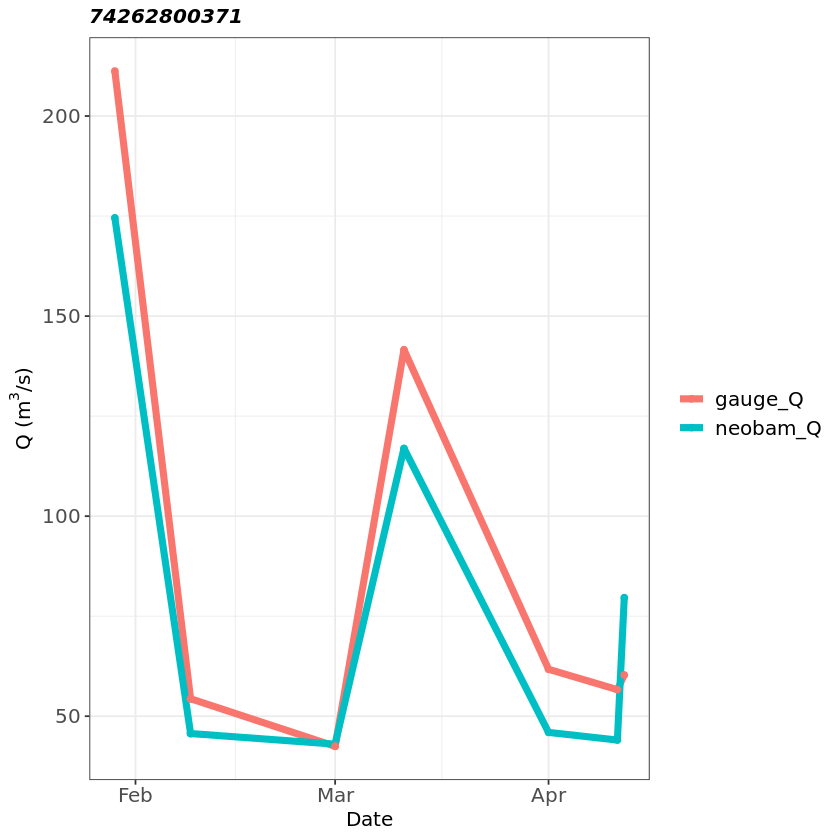

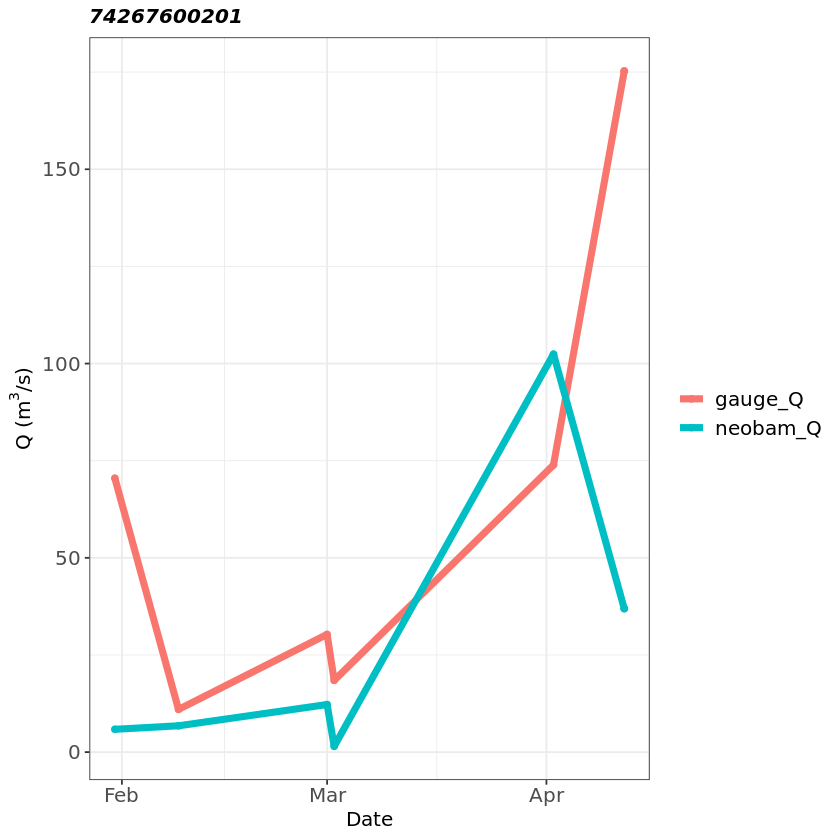

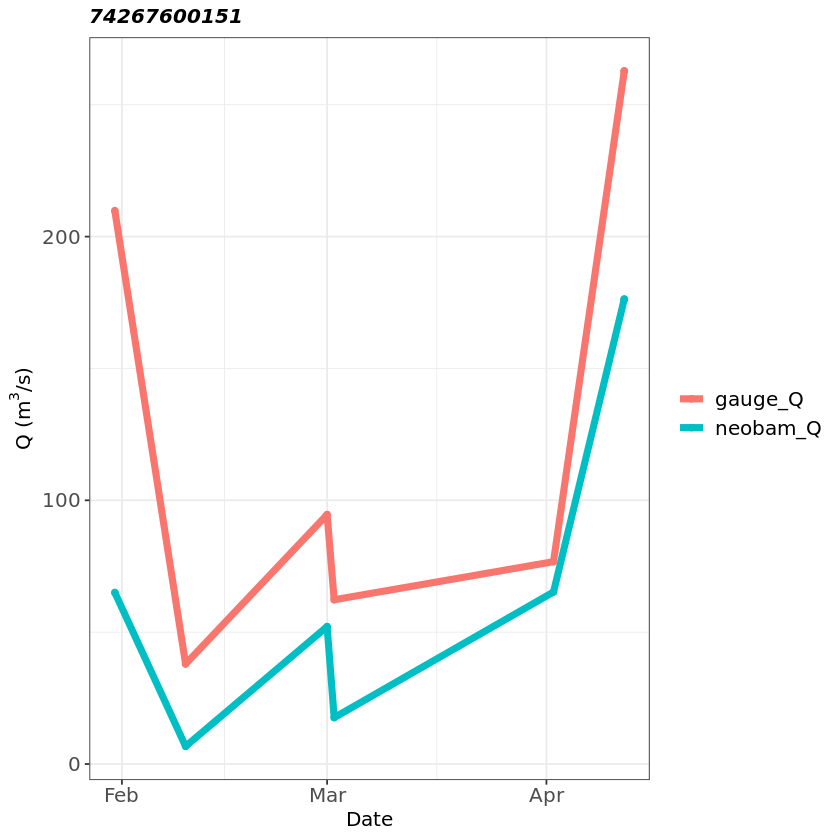

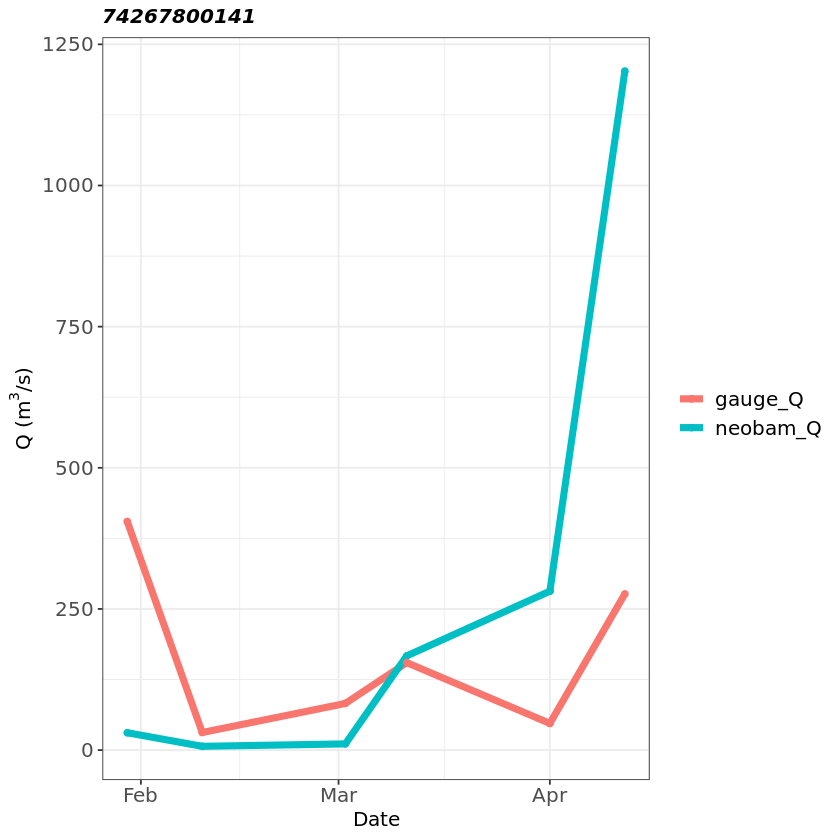

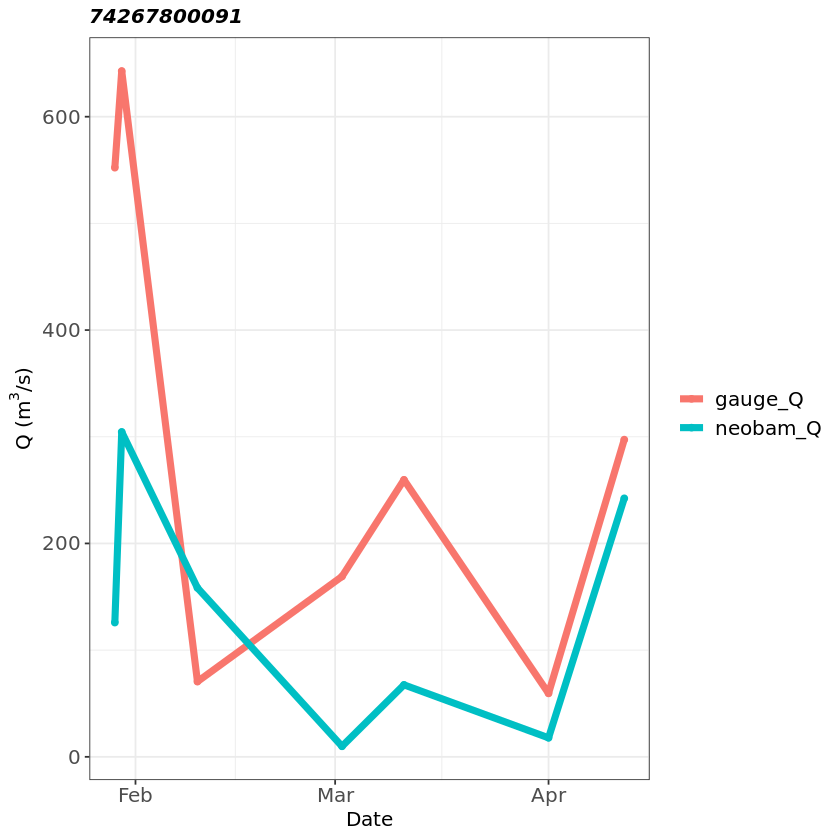

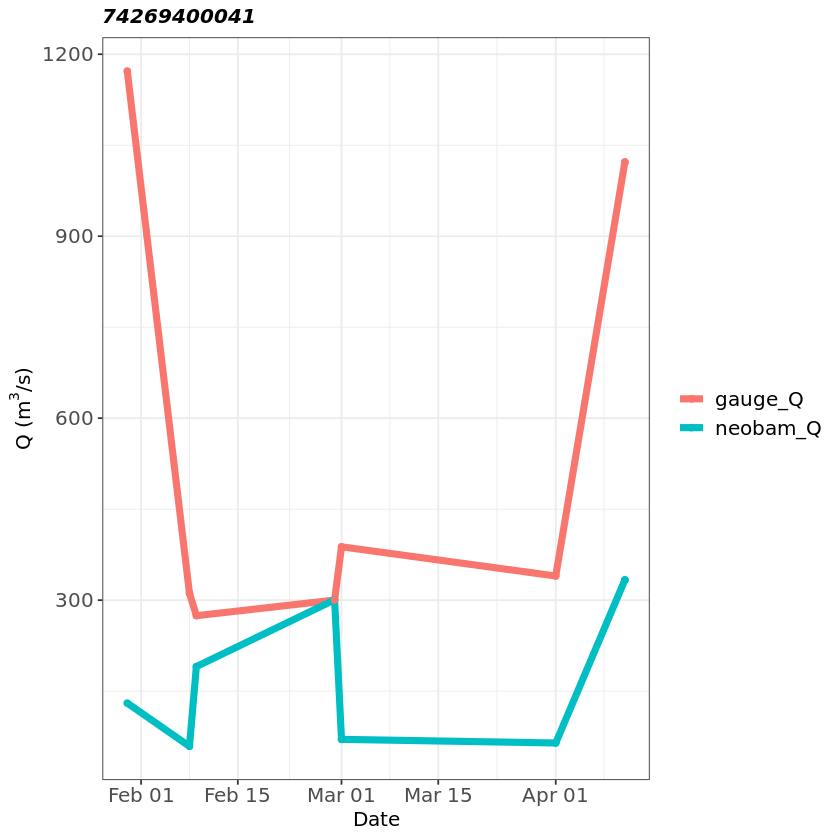

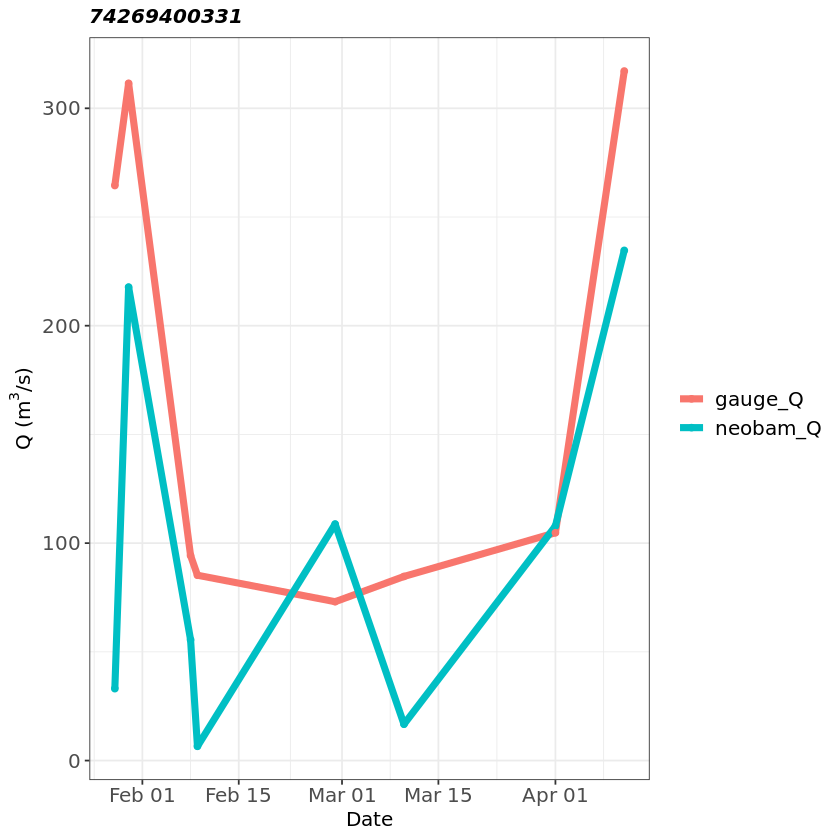

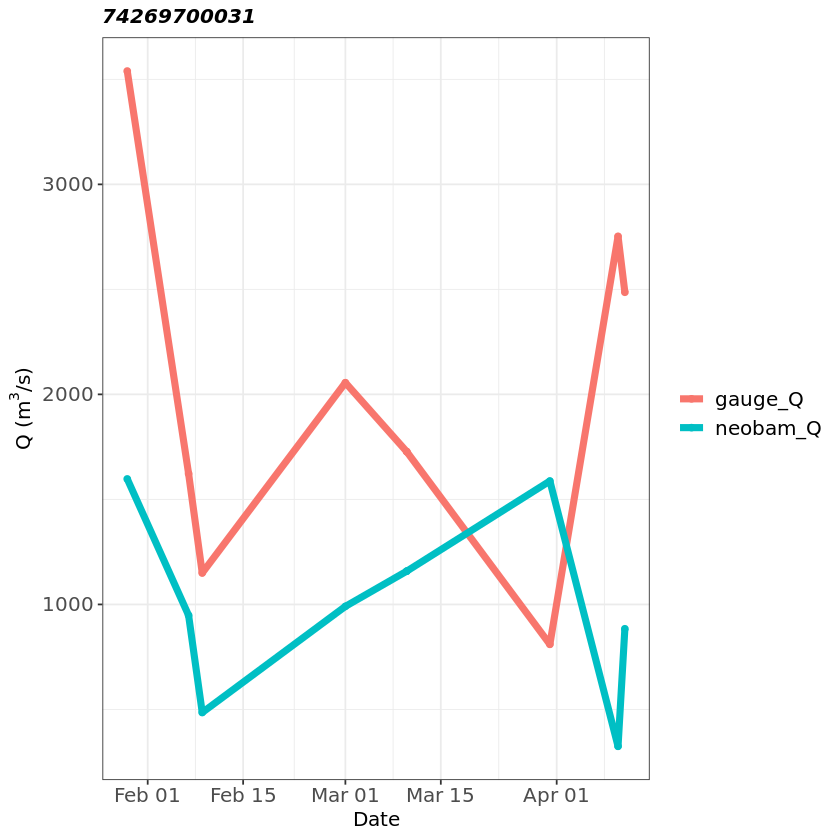

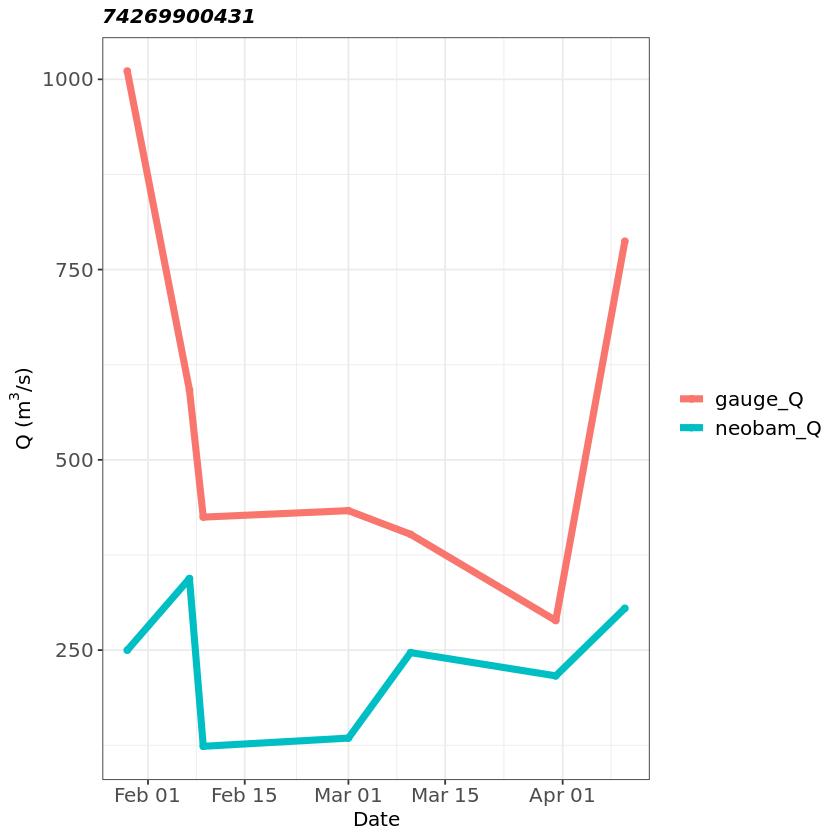

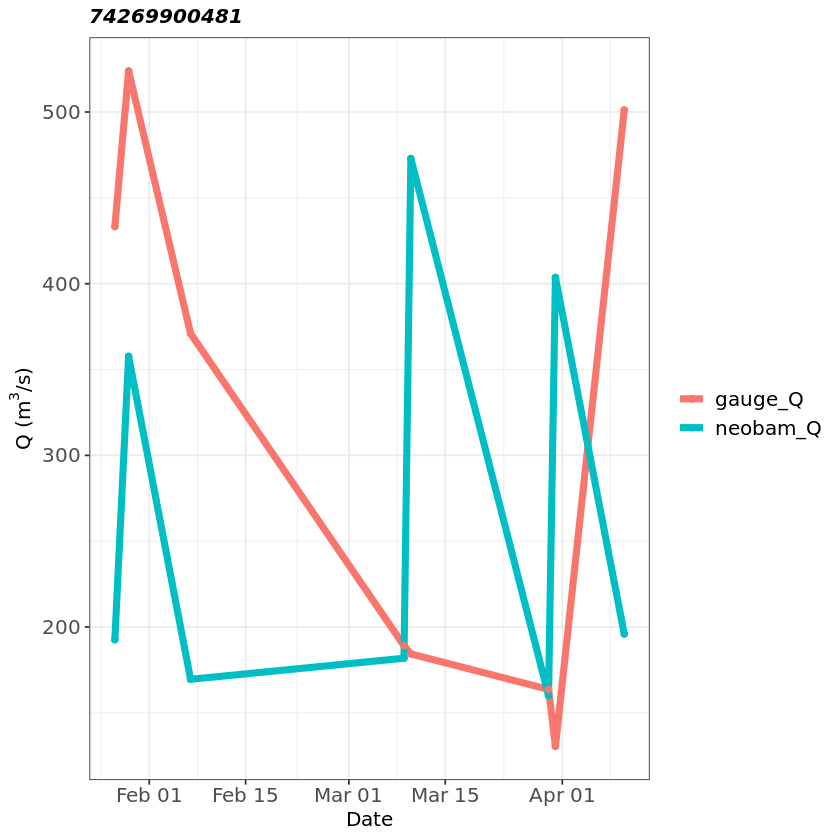

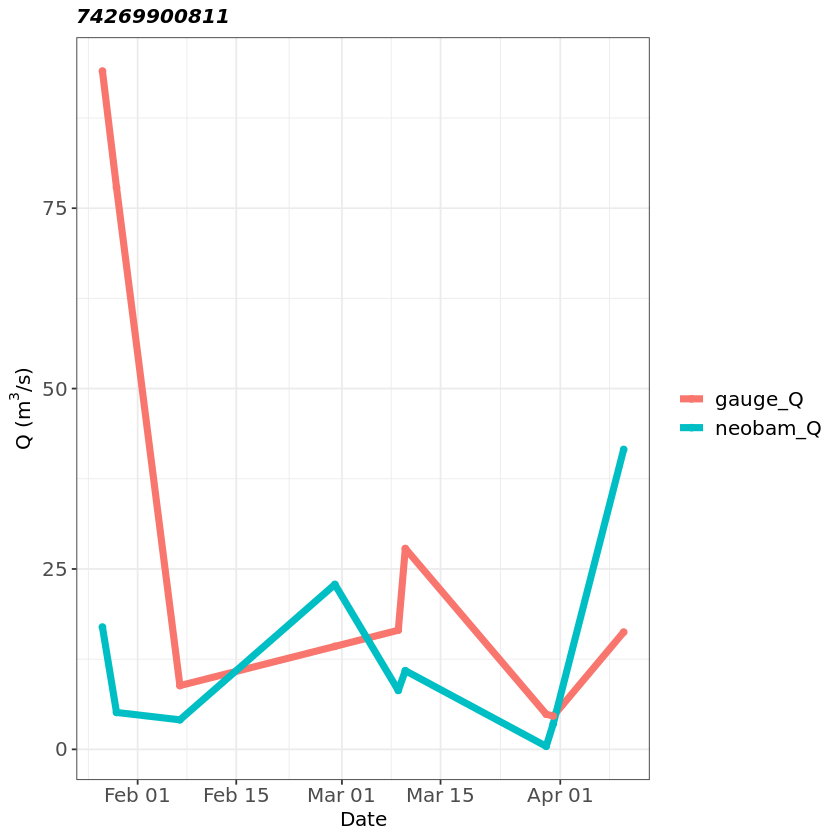

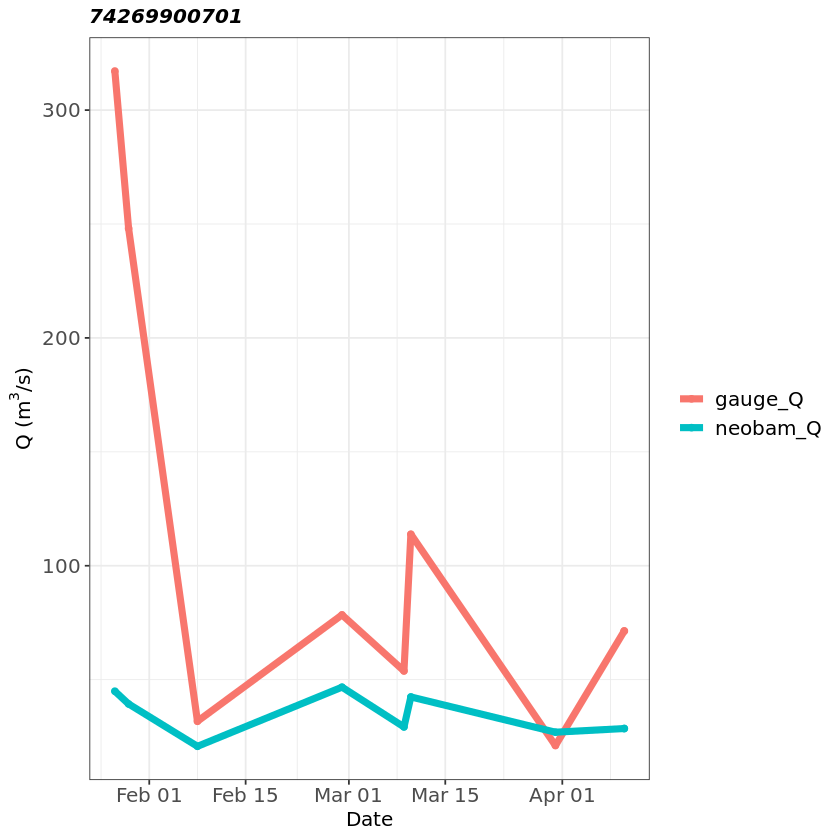

In [53]:
for (file in list.files('/nas/cee-water/cjgleason/colin/neobam/tempoutput/',full.names=TRUE)){
     # print(neobam_output)
neobam_output=readRDS(file)

if(is.null(neobam_output[[1]]$posteriors[[1]]$r$sd)){
    
    # print(neobam_output[[1]])
    

library(ggplot2)
library(ncdf4)
reach_id=neobam_output[[1]]$reach_id


swot_file= paste0('/nas/cee-water/cjgleason/SWOT_Q_UMASS/mnt/input/swot/',reach_id,
         '_SWOT.nc')     
#  swot = open.nc(swot_file)
# reach_grp = grp.inq.nc(swot, "reach")$self
# time = var.get.nc(reach_grp, "time")

swot=nc_open(swot_file)
time=ncvar_get(swot,'reach/time')
    
    invalid_times=neobam_output[[1]]$invalid_times
    
 if(length(invalid_times)==0){
     neobam_time=time}else{
  neobam_time = time[-invalid_times]}

  neobam_dt=as.character(as.Date(as.Date(neobam_time/86400,origin = '2000-01-01'),format='%Y%m%d'))
 nc_close(swot)

 # priors=open.nc("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")
priors=nc_open("/nas/cee-water/cjgleason/SWOT_Q_UMASS/na_sword_v16_SOS_priors.nc")

# priors_reach_grp=grp.inq.nc(priors,"reaches")$self
# priors_reach_index=which(var.get.nc(priors_reach_grp,'reach_id')==reach_id)

priors_reach_index=which(ncvar_get(priors,'USGS/USGS_reach_id')==reach_id)

# print(priors_reach_index)
#  gauge_grp=grp.inq.nc(priors, "USGS")$self
#  gauge_time=var.get.nc(gauge_grp,'USGS_qt')#[priors_reach_index,]
#  gauge_Q=var.get.nc(gauge_grp,'USGS_q')[priors_reach_index,]

gauge_time=t(ncvar_get(priors,'USGS/USGS_qt'))[priors_reach_index,]
gauge_Q=t(ncvar_get(priors,'USGS/USGS_q'))[priors_reach_index,]

 nc_close(priors)

 gauge_dt= as.character(as.Date(gauge_time, origin = '0001-01-01'))


  gauge_in_neobam_index=which(gauge_dt %in% neobam_dt)
        
 plotter_neobam= data.frame('neobam_Q'=neobam_output[[1]]$posterior_Q,
                            'time'=neobam_dt)

plotter_gauge= data.frame('gauge_Q'=gauge_Q[gauge_in_neobam_index],
                    'time'=gauge_dt[gauge_in_neobam_index])

plotter=left_join(plotter_neobam,plotter_gauge,by='time')%>%
      group_by(time)%>%
      mutate(neobam_Q=mean(neobam_Q))%>%
gather(source,flow,-time)%>%
mutate(time=as.POSIXct(time))

               
     nt=neobam_output$nt 

p1=ggplot(plotter)+
geom_line(aes(x=time,y=flow,col=source),lwd=2)+
    geom_point(aes(x=time,y=flow,col=source))+
  ylab(expression(paste("Q (",m^3, "/s)", sep="")))+
    xlab("Date")+
    # ylim(c(0,1))+
   # coord_cartesian(ylim=c(-5, 1))+
      theme_bw() +
   # annotate('text',x=min(plotter$date),y=1.0*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_posterior=',formatC(neobam_rrmse_posterior,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.95*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_posterior=',formatC(neobam_NSE_posterior,digits=2)) , size=4,hjust = 0) +
   #  annotate('text',x=min(plotter$date),y=0.90*max(plotter$flow,na.rm=T),
   #           label= paste('rrmse_recon=',formatC(neobam_rrmse_recon,digits=2)) , size=4,hjust = 0) +
   # annotate('text',x=min(plotter$date),y=0.85*max(plotter$flow,na.rm=T), 
   #           label= paste('NSE_recon=',formatC(neobam_NSE_recon,digits=2)) , size=4,hjust = 0) +
    ggtitle(reach_id)+

     # scale_y_continuous(breaks=seq(1,18))+
      theme(legend.text=element_text(size=12),
        legend.title=element_blank(),
            
        #legend.position =c(0.8,0.8),
        axis.text.y= element_text(size=12),
        #legend.position = 'none',
        axis.text.x =element_text(size=12),
        #axis.text.x=element_blank(),
        axis.title.x= element_text(size=12),
            axis.title.y= element_text(size=12),
        #panel.grid.major = element_line(colour = "grey50"),
        plot.title = element_text(color="black", size=12, face="bold.italic")) 
       # legend.background = element_rect(fill=alpha('white',0.8)))
        #axis.text.x = element_text(angle =45, vjust = 1, hjust=1))  
         
        plot(p1)
    
    }
    
    }
    
    
      
